In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import torch
import torchvision
import torchsummary
import torchmetrics
from sklearn.metrics import average_precision_score
from torch.utils.tensorboard import SummaryWriter

In [3]:
from utils import do_train, predict_test

In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
NAME_MODEL = 'efficientnet_b7_augmentation'

In [6]:
if torch.cuda.is_available():
    print('There is GPU')

There is GPU


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
CANTIDAD_CLASES = 2
ANCHO_IMAGENES = 224
ALTO_IMAGENES = 224

In [9]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES), scale=(0.5, 1.0)),
                        torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
                        torchvision.transforms.ToTensor()
                      ])

data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

train_set = torchvision.datasets.ImageFolder(root='P2datasetFull/train/', transform=aug_data_transforms)
valid_set = torchvision.datasets.ImageFolder(root='P2datasetFull/val1/', transform=data_transforms)
test_set = torchvision.datasets.ImageFolder(root='P2datasetFull/test1/', transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

In [10]:
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
weights = EfficientNet_B7_Weights.IMAGENET1K_V1
transforms = weights.transforms()

model = torchvision.models.efficientnet_b7(weights=weights)

model.to(device)

torchsummary.summary(model, input_size=(3, 224, 224))
# model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,728
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              SiLU-3         [-1, 64, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]             576
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              SiLU-6         [-1, 64, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
            Conv2d-8             [-1, 16, 1, 1]           1,040
              SiLU-9             [-1, 16, 1, 1]               0
           Conv2d-10             [-1, 64, 1, 1]           1,088
          Sigmoid-11             [-1, 64, 1, 1]               0
SqueezeExcitation-12         [-1, 64, 112, 112]               0
           Conv2d-13         [-1, 32, 112, 112]           2,048
      BatchNorm2d-14         [-1, 32, 1

In [11]:
list(model.named_children())[-1]

('classifier',
 Sequential(
   (0): Dropout(p=0.5, inplace=True)
   (1): Linear(in_features=2560, out_features=1000, bias=True)
 ))

In [12]:
model.classifier[1]

Linear(in_features=2560, out_features=1000, bias=True)

In [13]:
for param in model.parameters():
    param.requires_grad = False

In [14]:
last_layer_in_features = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

In [15]:
model_optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_loss = torch.nn.CrossEntropyLoss()
model_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
model_data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

model_writer = {"train": SummaryWriter(log_dir=f"data_{NAME_MODEL}/{NAME_MODEL}_model_train"),
                "valid": SummaryWriter(log_dir=f"data_{NAME_MODEL}/{NAME_MODEL}_model_valid")}

history = do_train(model.to("cpu"), 
                model_optimizer, 
                model_loss, 
                model_metric,
                model_data,
                20,
                device,
                model_writer)

Epoch: 1/20 - Train loss 0.588622 - Train Accuracy 0.739820 - Valid Loss 0.489048 - Valid Accuracy 0.882939
Epoch: 2/20 - Train loss 0.472362 - Train Accuracy 0.826212 - Valid Loss 0.404596 - Valid Accuracy 0.889201
Epoch: 3/20 - Train loss 0.414146 - Train Accuracy 0.857548 - Valid Loss 0.361815 - Valid Accuracy 0.892086
Epoch: 4/20 - Train loss 0.383170 - Train Accuracy 0.859314 - Valid Loss 0.333658 - Valid Accuracy 0.896721
Epoch: 5/20 - Train loss 0.362731 - Train Accuracy 0.862098 - Valid Loss 0.313526 - Valid Accuracy 0.900247
Epoch: 6/20 - Train loss 0.344712 - Train Accuracy 0.870634 - Valid Loss 0.297443 - Valid Accuracy 0.902083
Epoch: 7/20 - Train loss 0.333826 - Train Accuracy 0.872216 - Valid Loss 0.285866 - Valid Accuracy 0.903452
Epoch: 8/20 - Train loss 0.318868 - Train Accuracy 0.881856 - Valid Loss 0.276726 - Valid Accuracy 0.904327
Epoch: 9/20 - Train loss 0.320519 - Train Accuracy 0.870462 - Valid Loss 0.269820 - Valid Accuracy 0.905461
Epoch: 10/20 - Train loss 0.

In [16]:
torch.save(model.state_dict(), f'{NAME_MODEL}.pth')

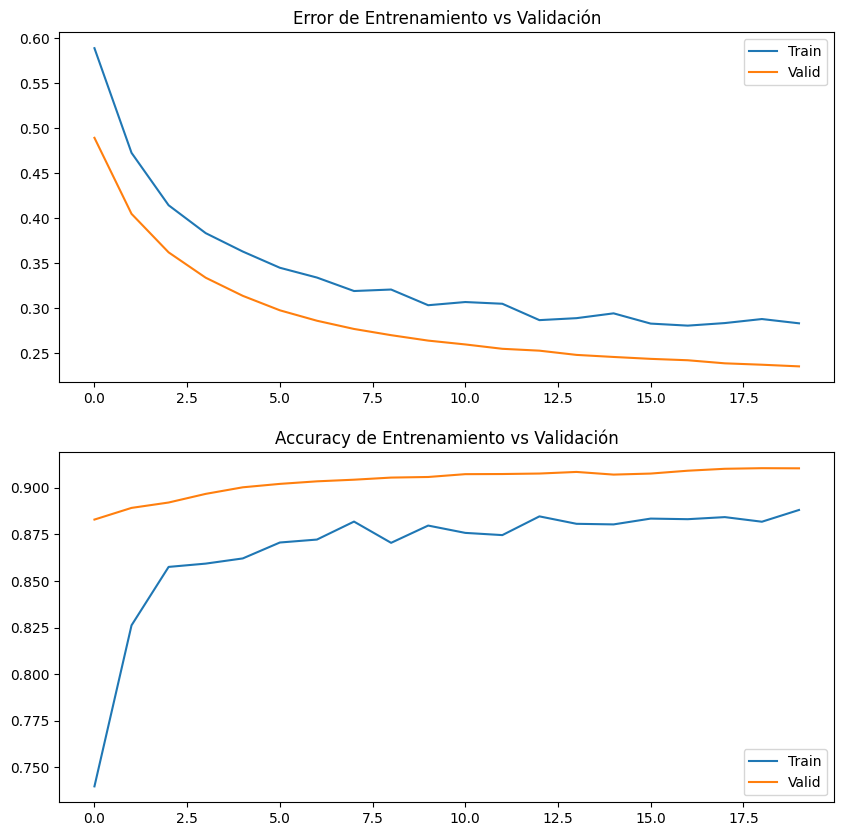

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

In [18]:
predict_test(model, test_loader)

Total images: 6216
PR_AUC: 0.9753631322676964
Accuracy: 92.21364221364222
